In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

In [2]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

## Extra-quick version: Get interpolated & averaged IFS-FESOM (TCo2559-NG5) Cycle 3 data and create quick plots

In [117]:
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

In [121]:
cat.IFS

IFS:
  args:
    path: https://raw.githubusercontent.com/nextGEMS/catalog/main/IFS/main.yaml
  description: IFS model output
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://nextgems.github.io/catalog


In [122]:
# which IFS experiments are available? Which streams are in the IFS catalog for experiment 'tco2559-ng5-cycle3'?
print(list(cat.IFS))
print(list(cat.IFS['tco2559-ng5-cycle3'])) # will be IFS_4.4-FESOM_5-cycle3

['tco2559-ng5-cycle3']
['2D_1h_native', '3D_6h_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', 'WAM_1h_native']


In [123]:
ds = cat.IFS['tco2559-ng5-cycle3']['2D_monthly_0.25deg'].to_dask() # load medium-resolution here, monthly means

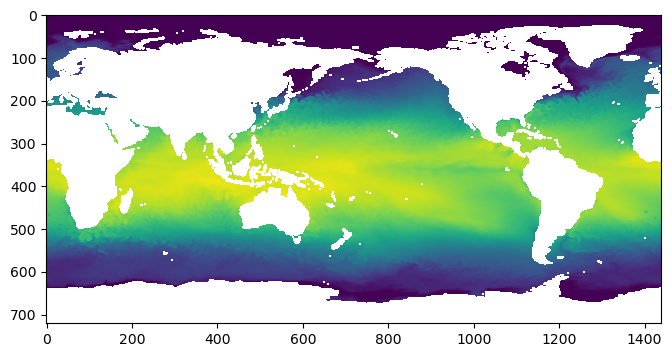

In [124]:
# reshape to (#lat x #lon) numpy array
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
sample = np.reshape(ds['sst'].isel(time=0).values, newshape=(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
plt.imshow(sample)

Text(0.5, 1.0, 'Global-mean SST time series')

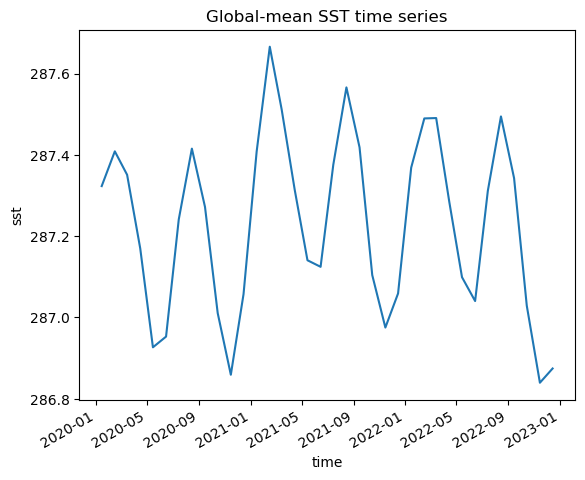

In [67]:
ds['sst'].mean("value").plot() # will need area-weighting
plt.title("Global-mean SST time series")

Text(0.5, 1.0, 'Zonal-mean total precipitation')

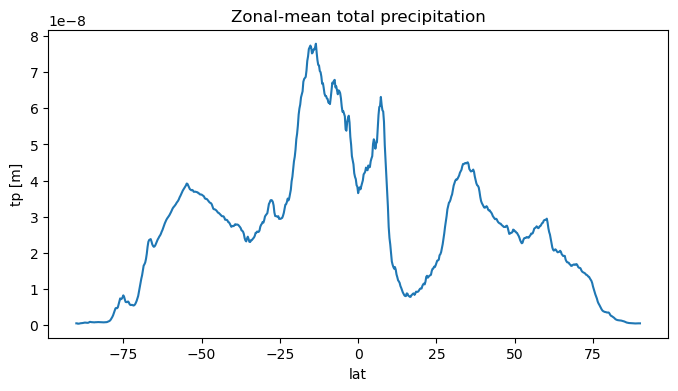

In [97]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
cat.IFS['tco2559-ng5-cycle3']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].isel(time=0).groupby("lat").mean().plot(ax=ax)
plt.title('Zonal-mean total precipitation')

Text(0.5, 1.0, 'Hovmoeller plot of total precipitation')

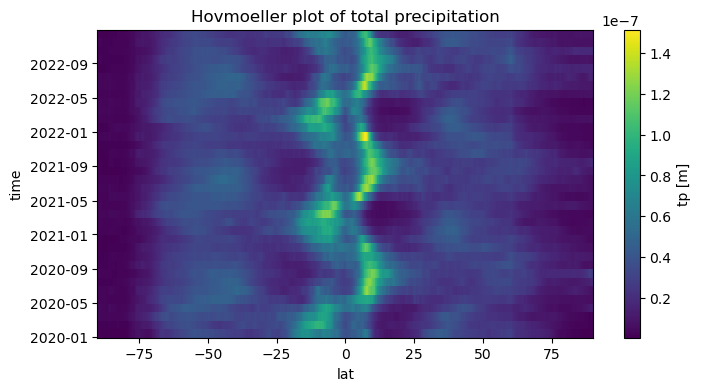

In [69]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
cat.IFS['tco2559-ng5-cycle3']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].groupby("lat").mean().plot(ax=ax)
plt.title('Hovmoeller plot of total precipitation')

## Slightly longer version: Get high-frequency, native IFS-FESOM (TCo2559-NG5) Cycle 3 data and make a plot

In [106]:
cat = intake.open_catalog("https://nextgems.github.io/catalog/catalog.yaml")

In [107]:
# which IFS experiments are available?
print(list(cat.IFS))

['tco2559-ng5-cycle3']


In [108]:
# which other streams are in the IFS catalog?
print(list(cat.IFS['tco2559-ng5-cycle3'])) 

['2D_1h_native', '3D_6h_native', '2D_monthly_0.25deg', '3D_monthly_0.25deg', 'WAM_1h_native']


In [73]:
data = cat.IFS['tco2559-ng5-cycle3']['2D_1h_native'].to_dask() # pick highest frequency (1-hourly), highest spatial resolution (4.4km)

#### list all 2D variables; click arrow next to 'Data variables" to see the list; click the icons at the end of each row for more info, such as long name and shape

In [74]:
data

<xarray.Dataset>
Dimensions:  (time: 25849, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Dimensions without coordinates: value
Data variables: (12/59)
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2t       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    zos      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

#### Get the model IFS grid (points_ifs)

In [75]:
model_lon = data.lon.values
model_lat = data.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

#### Interpolate an example variable to a small target grid; here: zoom of Europe (lon2, lat2)

In [76]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

#### Pick the example variable and do the actual interpolation

In [77]:
data_sample = data['sst'][1,:]

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

#### Plot it

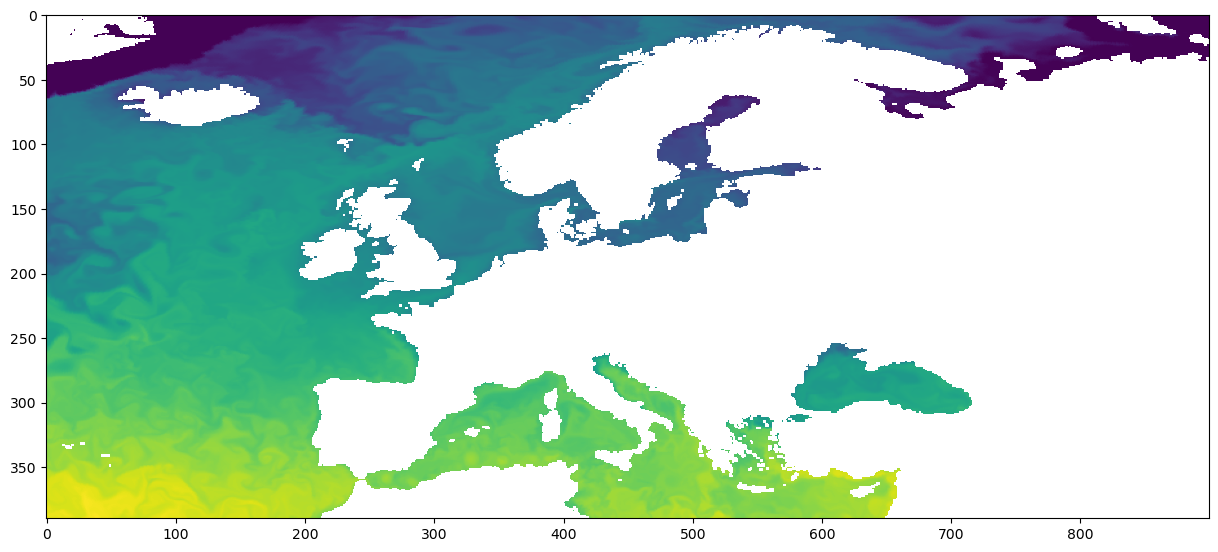

In [78]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Long version

In [79]:
data['2t'] # pick any variable here

<xarray.DataArray '2t' (time: 25849, value: 26306560)>
dask.array<open_dataset-1aa8dccb9c4052ceb516597c30e42f1d2t, shape=(25849, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

look at the variables by taking the first time step, but all spatial points

In [80]:
data_sample = data['2t'][0,:]
data_sample

<xarray.DataArray '2t' (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [81]:
data_sample.shape # the number of points

(26306560,)

In [82]:
data_sample.values # access the actual values, this can take a short moment

array([245.52464294, 245.53440857, 245.55393982, ..., 242.46995544,
       242.48753357, 242.50315857])

In [83]:
nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan]) # create an interpolator, this takes a moment 

In [84]:
interpolated_nn = nn_interpolation((lon2, lat2)) # this step is quite fast and performs the actual interpolation to the target grid

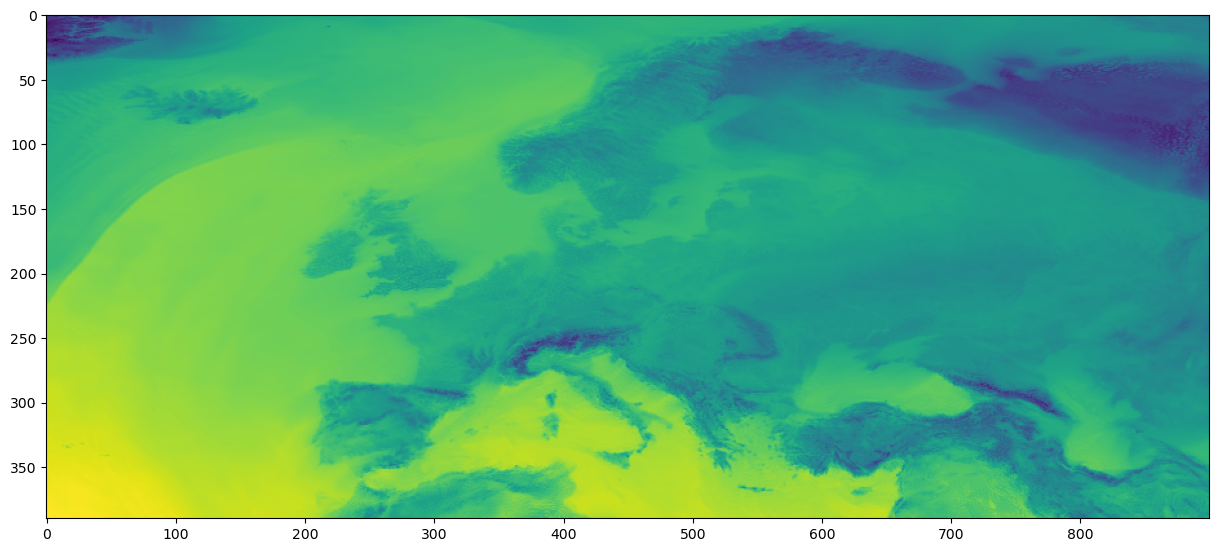

In [85]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Find a point on the map and plot timeseries

In [86]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [87]:
# the point we are interesting in
lon_target = -10
lat_target = 50

In [88]:
points = np.array([[lat_target],[lon_target]])

In [89]:
index = tunnel_fast1d(model_lon, model_lat, points)

In [90]:
# in the model, this is the point
model_lon[index[0]], model_lat[index[0]]

(349.9912434325744, 50.004882010120575)

In [91]:
data['2t'] # first dimension is time, second dimension is spatial dimension

<xarray.DataArray '2t' (time: 25849, value: 26306560)>
dask.array<open_dataset-1aa8dccb9c4052ceb516597c30e42f1d2t, shape=(25849, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [92]:
data['2t'][:, index[0]] # this would read all time steps for this point 

<xarray.DataArray '2t' (time: 25849)>
dask.array<getitem, shape=(25849,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2023-01-01
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

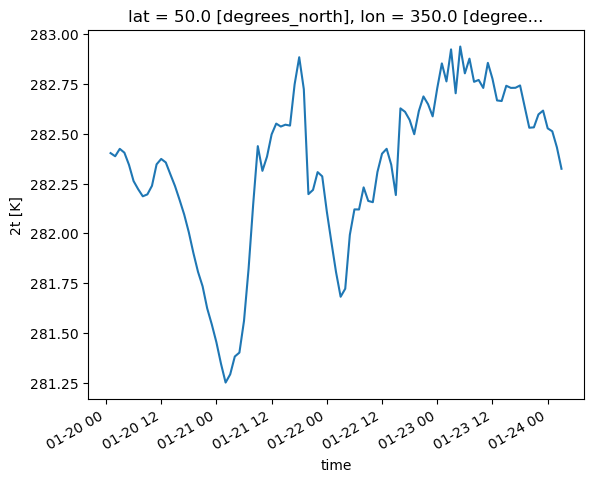

In [93]:
data['2t'][1:100, index[0]].plot() # just plot the first 100 steps, note the actual time is plotted on the x axis as well

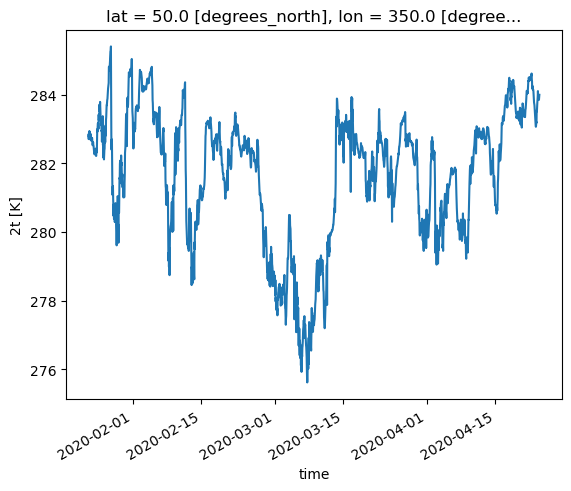

In [94]:
data['2t'].sel(time=slice('2020-01-23','2020-04-23'))[:,index[0]].plot() # plot three months